In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets

In [2]:
customers = pd.read_csv('/Users/varsharani/Downloads/Customers.csv')
products = pd.read_csv('/Users/varsharani/Downloads/Products.csv')
transactions = pd.read_csv('/Users/varsharani/Downloads/Transactions.csv')

# Checking missing Value and drop duplicate

In [3]:
#missing values
print(customers.isnull().sum())
print(products.isnull().sum())
print(transactions.isnull().sum())

# Drop duplicates
customers.drop_duplicates(inplace=True)
products.drop_duplicates(inplace=True)
transactions.drop_duplicates(inplace=True)

CustomerID      0
CustomerName    0
Region          0
SignupDate      0
dtype: int64
ProductID      0
ProductName    0
Category       0
Price          0
dtype: int64
TransactionID      0
CustomerID         0
ProductID          0
TransactionDate    0
Quantity           0
TotalValue         0
Price              0
dtype: int64


In [4]:
# Convert dates to datetime
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
transactions['TransactionDate'] = pd.to_datetime(transactions['TransactionDate'])

In [5]:
# Merge datasets
data = transactions.merge(customers, on='CustomerID',  how='left')
data = data.merge(products, on='ProductID',  how='left')

print(data)

    TransactionID CustomerID ProductID     TransactionDate  Quantity  \
0          T00001      C0199      P067 2024-08-25 12:38:23         1   
1          T00112      C0146      P067 2024-05-27 22:23:54         1   
2          T00166      C0127      P067 2024-04-25 07:38:55         1   
3          T00272      C0087      P067 2024-03-26 22:55:37         2   
4          T00363      C0070      P067 2024-03-21 15:10:10         3   
..            ...        ...       ...                 ...       ...   
995        T00496      C0118      P037 2024-10-24 08:30:27         1   
996        T00759      C0059      P037 2024-06-04 02:15:24         3   
997        T00922      C0018      P037 2024-04-05 13:05:32         4   
998        T00959      C0115      P037 2024-09-29 10:16:02         2   
999        T00992      C0024      P037 2024-04-21 10:52:24         1   

     TotalValue  Price_x          CustomerName         Region SignupDate  \
0        300.68   300.68        Andrea Jenkins         Euro

In [6]:
print(products.columns)

Index(['ProductID', 'ProductName', 'Category', 'Price'], dtype='object')


In [7]:
# Checking for outliers

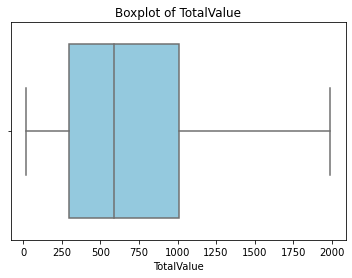

In [8]:
# Boxplot for 'TotalValue' column in transactions
sns.boxplot(data=data, x=data['TotalValue'], color='skyblue')
plt.title('Boxplot of TotalValue')
plt.xlabel('TotalValue')
plt.show()


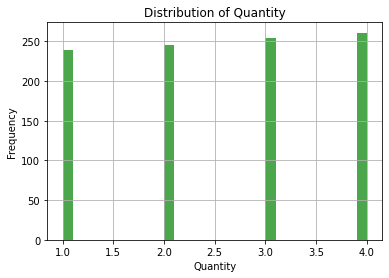

In [9]:
# Histogram for 'Quantity'
data['Quantity'].hist(bins=30, color='green', alpha=0.7)
plt.title('Distribution of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

In [10]:
# Aggregate transaction data (e.g., total spend per customer)
data_agg = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spend
    'Quantity': 'sum',    # Total quantity purchased
    'Price_x': 'mean',      # Average price of purchased products
    'Region': 'first',    # Region of customer
}).reset_index()

# Encode categorical variables
data_agg = pd.get_dummies(data_agg, columns=['Region'], drop_first=True)

print(data_agg)

    CustomerID  TotalValue  Quantity     Price_x  Region_Europe  \
0        C0001     3354.52        12  278.334000              0   
1        C0002     1862.74        10  208.920000              0   
2        C0003     2725.38        14  195.707500              0   
3        C0004     5354.88        23  240.636250              0   
4        C0005     2034.24         7  291.603333              0   
..         ...         ...       ...         ...            ...   
194      C0196     4982.88        12  416.992500              1   
195      C0197     1928.65         9  227.056667              1   
196      C0198      931.83         3  239.705000              1   
197      C0199     1979.28         9  250.610000              1   
198      C0200     4758.60        16  296.506000              0   

     Region_North America  Region_South America  
0                       0                     1  
1                       0                     0  
2                       0                    

# normalising features

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
numeric_cols = ['TotalValue', 'Quantity', 'Price_x']
data_agg[numeric_cols] = scaler.fit_transform(data_agg[numeric_cols])

# Train KNN Model

In [12]:
from sklearn.neighbors import NearestNeighbors

# Features to use in KNN
CustomerID = data_agg.drop(['CustomerID'], axis=1)

# Train the KNN model
knn = NearestNeighbors(n_neighbors=4, metric='manhattan')  # 4 includes the user itself
knn.fit(CustomerID)

NearestNeighbors(metric='manhattan', n_neighbors=4)

In [15]:
def get_top_3_lookalikes(customer_id):
    # Find the customer's index in the aggregated data
    customer_index = data_agg[data_agg['CustomerID'] == customer_id].index
    if len(customer_index) == 0:
        print(f"CustomerID {customer_id} not found in the data.")
        return pd.DataFrame()  # Return an empty DataFrame if the customer isn't found
    
    customer_index = customer_index[0]
    
    # Get the feature names and ensure proper format for kneighbors
    input_features = CustomerID.iloc[[customer_index]]  # Use double brackets to keep the DataFrame structure
    distances, indices = knn.kneighbors(input_features)

    # Extract similar customers (excluding the input customer itself)
    similar_indices = indices[0][1:]  # Skip the first one, which is the customer itself
    similar_distances = distances[0][1:]
    similar_customers = data_agg.iloc[similar_indices].copy()  # Use `.copy()` to avoid SettingWithCopyWarning
    similar_customers.loc[:, 'SimilarityScore'] = 1 / (1 + similar_distances)  # Inverse of distance as score

    # Return top 3 customers and similarity scores
    top_3 = similar_customers[['CustomerID', 'SimilarityScore']].head(3)
    return top_3

In [16]:
lookalike_map = {}

# For each of the first 20 customers (C0001 to C0020), get the top 3 lookalikes
for i in range(1, 21):
    customer_id = f'C{i:04d}'  # C0001, C0002, ..., C0020
    top_3 = get_top_3_lookalikes(customer_id)
    
    # Check if top_3 is not empty before storing the results
    if not top_3.empty:
        # Store the results in the dictionary (Map<cust_id, List<cust_id, score>>)
        lookalike_map[customer_id] = top_3.values.tolist()

# Convert the dictionary to a DataFrame for saving to CSV
lookalike_df = pd.DataFrame([
    {'CustomerID': key, 'Lookalikes': value} 
    for key, value in lookalike_map.items()
])

# Save the lookalike data to Lookalike.csv
lookalike_df.to_csv('Lookalike.csv', index=False)

# Optionally, print out the first few records to verify
print(lookalike_df.head())

  CustomerID                                         Lookalikes
0      C0001  [[C0137, 0.9461670913643142], [C0191, 0.928898...
1      C0002  [[C0088, 0.9302941660002525], [C0142, 0.906780...
2      C0003  [[C0190, 0.9273430178198157], [C0147, 0.909024...
3      C0004  [[C0113, 0.8873011894892588], [C0012, 0.828661...
4      C0005  [[C0186, 0.9217917724313268], [C0140, 0.919887...
